In [1]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.display.max_rows = 2000
import matplotlib
matplotlib.rcParams['figure.figsize'] = (24,4)
matplotlib.style.use('ggplot')
#data <- read.csv("C:/Users/p0p/Desktop/anaomaly/Example-3.csv", sep=",")

In [2]:
data = pd.read_csv(os.getcwd() + "\\2.csv")

In [3]:
data['time'] = pd.to_datetime(data.time)
data = data.set_index('time')
#data['new_col'] = data['value'].rolling(144).mean()

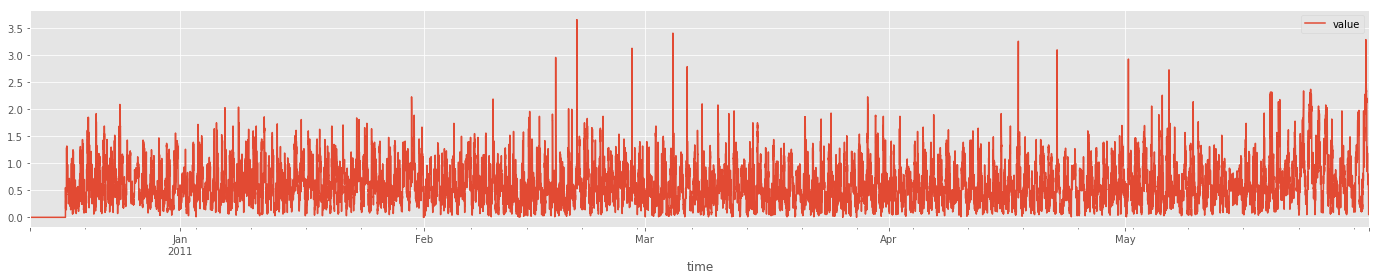

In [4]:
data.plot()

In [5]:
data.head()

,value
time,
2010-12-13 00:00:00,0.0
2010-12-13 00:10:00,0.0
2010-12-13 00:20:00,0.0
2010-12-13 00:30:00,0.0
2010-12-13 00:40:00,0.0


In [9]:
from datetime import date
from dateutil.rrule import rrule, DAILY
a = date(2010, 12, 13)
b = date(2011, 5, 31)
k = []
# Monday is 0 and Sunday is 6
for dt in rrule(DAILY, dtstart=a, until=b):
    k.append(np.append(dt.weekday(),data[dt.strftime("%Y-%m-%d")].value.values.reshape(144,)))
    data.loc[dt.strftime("%Y-%m-%d"),'weekday'] = dt.weekday()

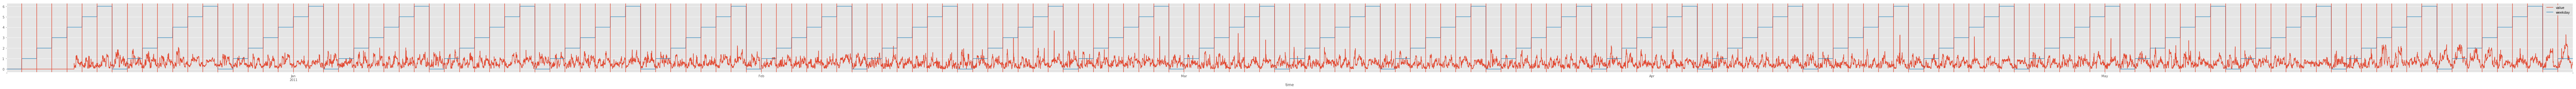

In [10]:
data.loc[:,['value','weekday']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))
#plot weekday and graph

In [11]:
anomalies = ['2011-03-04',
'2011-03-06',
'2011-04-17',
'2011-04-22',
'2011-05-06',
'2011-05-19',
'2011-05-20',
'2011-05-22',
'2011-05-23',
'2011-05-24',
'2011-05-30']

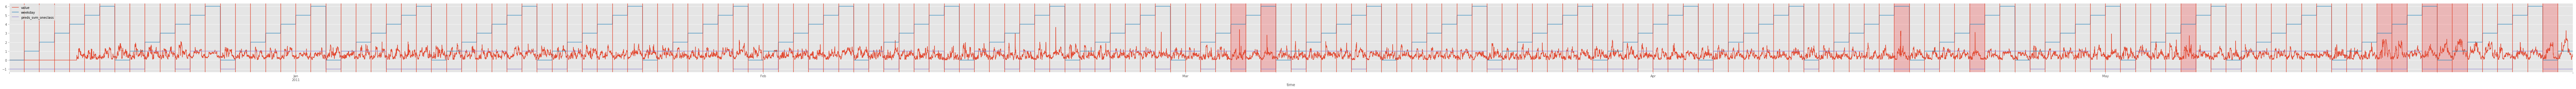

In [53]:
# applyng svm
from sklearn.svm import OneClassSVM
from datetime import date,timedelta
abc = OneClassSVM()
abc.fit(np.array(k))
from sklearn import metrics 
preds = abc.predict(np.array(k)) 
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_svm_oneclass'] = preds[i]
    i = i + 1
data.loc[:,['value','weekday','preds_svm_oneclass']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))
    if dt.strftime("%Y-%m-%d") in anomalies: 
        plt.axvspan(dt, dt+ timedelta(days=1), color='r', alpha=0.2)

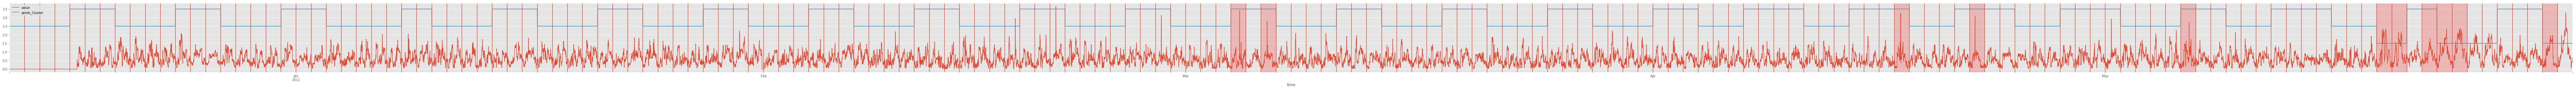

In [54]:
#applying kmeans
from sklearn.cluster import KMeans
X = np.array(k)
kmeans = KMeans(n_clusters=3, random_state=42).fit(X)
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_Cluster'] = kmeans.labels_[i]+1.5
    i = i +1
data.loc[:,['value','preds_Cluster']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))
    if dt.strftime("%Y-%m-%d") in anomalies: 
        plt.axvspan(dt, dt+ timedelta(days=1), color='r', alpha=0.2)

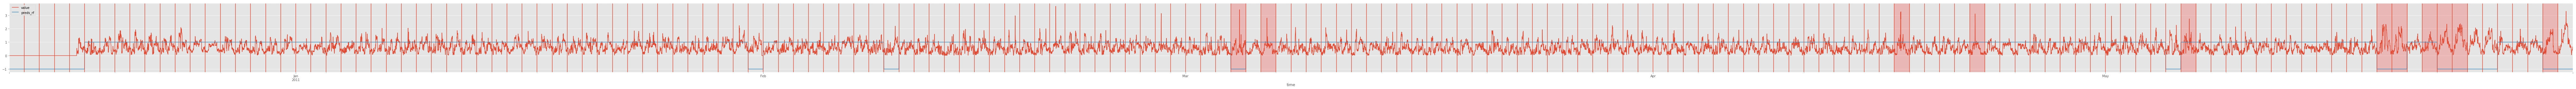

In [67]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
# Generate train data
X_train = np.array(k)
# fit the model
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_rf'] = y_pred_train[i]
    i = i +1
data.loc[:,['value','preds_rf']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))
    if dt.strftime("%Y-%m-%d") in anomalies: 
        plt.axvspan(dt, dt+ timedelta(days=1), color='r', alpha=0.2)

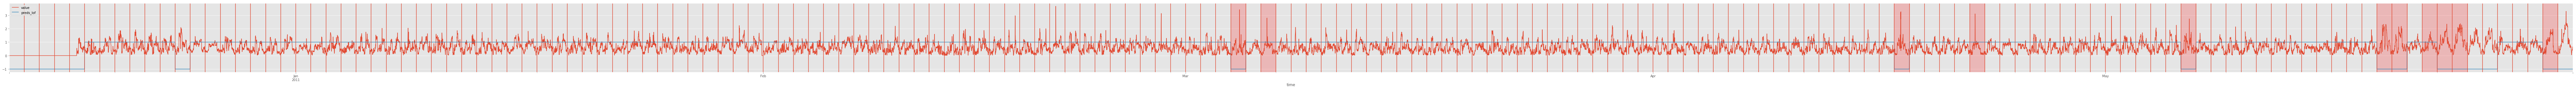

In [66]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=15,contamination=0.1)
y_pred = clf.fit_predict(np.array(k))
i = 0
for dt in rrule(DAILY, dtstart=a, until=b):
    data.loc[dt.strftime("%Y-%m-%d"),'preds_lof'] = y_pred[i]
    i = i +1
data.loc[:,['value','preds_lof']].plot(figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"))
    if dt.strftime("%Y-%m-%d") in anomalies: 
        plt.axvspan(dt, dt+ timedelta(days=1), color='r', alpha=0.2)
plt.legend()

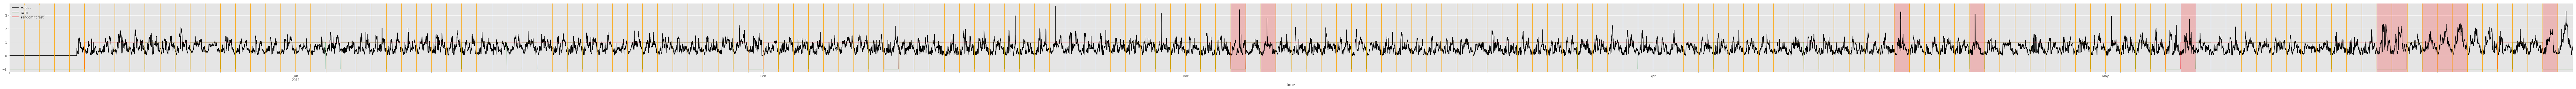

In [58]:
#svm vs random forest
data.value.plot(color='black', label='values',figsize=(144, 4))
data.preds_svm_oneclass.plot(color='green', label='svm',figsize=(144, 4))
#data.preds_Cluster.plot(color='blue', label='kmeans',figsize=(144, 4))
data.preds_rf.plot(color='red', label='random forest',figsize=(144, 4))
for dt in rrule(DAILY, dtstart=a, until=b):
    plt.axvline(x=dt.strftime("%Y-%m-%d"),color='orange')
    if dt.strftime("%Y-%m-%d") in anomalies: 
        plt.axvspan(dt, dt+ timedelta(days=1), color='r', alpha=0.2)
plt.legend(loc = 'best')